In [3]:
%pip install torchvision
%pip install torchmetrics

   ---------------------------------------- 0.0/868.8 kB ? eta -:--:--
   ------- -------------------------------- 153.6/868.8 kB 4.5 MB/s eta 0:00:01
   ------------------------- -------------- 563.2/868.8 kB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 868.8/868.8 kB 9.1 MB/s eta 0:00:00


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from collections import Counter


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((150, 150)),
    
])

train_dataset = datasets.ImageFolder(
    'archive/seg_train/seg_train', transform= transform)
dataloader_train = DataLoader(train_dataset, shuffle=True, num_workers=4)
print(train_dataset.classes)
print(train_dataset.class_to_idx)

test_dataset = datasets.ImageFolder(
    'archive/seg_test/seg_test', transform= transform
)
dataloader_test = DataLoader(test_dataset, shuffle=True, num_workers=4)
print(test_dataset.classes)
print(test_dataset.class_to_idx)

print(dict(Counter(train_dataset.targets)))


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 2191, 1: 2271, 2: 2404, 3: 2512, 4: 2274, 5: 2382}


torch.Size([1, 3, 150, 150])
Shape after squeezing channel dimension: torch.Size([3, 150, 150])


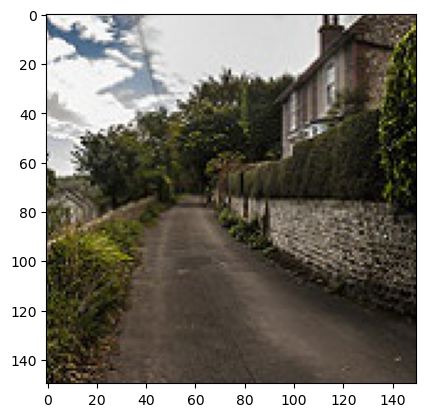

{tensor([4]): 1, tensor([2]): 1, tensor([5]): 1, tensor([2]): 1, tensor([4]): 1, tensor([4]): 1, tensor([5]): 1, tensor([1]): 1, tensor([0]): 1, tensor([4]): 1, tensor([2]): 1, tensor([4]): 1, tensor([0]): 1, tensor([0]): 1, tensor([2]): 1, tensor([4]): 1, tensor([5]): 1, tensor([2]): 1, tensor([5]): 1, tensor([5]): 1, tensor([2]): 1, tensor([4]): 1, tensor([4]): 1, tensor([4]): 1, tensor([1]): 1, tensor([5]): 1, tensor([1]): 1, tensor([3]): 1, tensor([5]): 1, tensor([2]): 1, tensor([0]): 1, tensor([2]): 1, tensor([0]): 1, tensor([1]): 1, tensor([4]): 1, tensor([3]): 1, tensor([5]): 1, tensor([0]): 1, tensor([5]): 1, tensor([1]): 1, tensor([2]): 1, tensor([2]): 1, tensor([3]): 1, tensor([0]): 1, tensor([3]): 1, tensor([3]): 1, tensor([2]): 1, tensor([0]): 1, tensor([1]): 1, tensor([1]): 1, tensor([4]): 1, tensor([1]): 1, tensor([1]): 1, tensor([5]): 1, tensor([5]): 1, tensor([5]): 1, tensor([5]): 1, tensor([3]): 1, tensor([1]): 1, tensor([0]): 1, tensor([4]): 1, tensor([3]): 1, tensor(

In [3]:
#Look at the data
image, label = next(iter(dataloader_train))
print(image.shape)
image = image.squeeze(0)
print("Shape after squeezing channel dimension:", image.shape)

image = image.permute(1, 2, 0)
plt.imshow(image)
plt.show()



In [9]:
#Building the Neural Network
class Intel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.mod = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),
            nn.Conv2d(32, 64, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),
            nn.Conv2d(64, 128, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),
            nn.Flatten(),
        )
        self.fc1 = nn.Linear(128 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    
    def forward(self, x):
        x = self.mod(x)
        x = self.fc1(x) 
        return self.fc2(x)

inte = Intel(num_classes= 6)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inte.parameters(), lr=0.01)

for epoch in range(10):
        for images , labels in dataloader_train:
            optimizer.zero_grad()
            outputs = inte(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            

In [11]:
met_accuracy = Accuracy(task='multiclass', num_classes= 6)
metric_precision = Precision( task="multiclass", num_classes=6, average="macro")
metric_recall = Recall( task="multiclass", num_classes=6, average="macro")
inte.eval()

with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = inte(images)
        _,preds = torch.max(outputs, 1)
        met_accuracy(preds, labels)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
    accuracy = met_accuracy.compute()
    precision = metric_precision.compute()
    recall = metric_recall.compute()
# test commit
print(accuracy)
print(precision)
print(recall)

tensor(0.1750)
tensor(0.0292)
tensor(0.1667)
